# Databases and SQL
---

Here I've taken a number of things from the *Data Basics* course for Python, which I'm going to go over at an accelerated pace.

We'll look at a contrived relational database through the package SQLite, and show how we can engage with this using Python. (Database example taken from [here](https://swcarpentry.github.io/sql-novice-survey/) which has some additional content on using [Python to write to the database too](https://swcarpentry.github.io/sql-novice-survey/10-prog/index.html))

If you get more into SQL and databases you should also maybe go through [this tutorial](https://www.pythoncentral.io/introductory-tutorial-python-sqlalchemy/) on SQLalchemy.

On the other side of things, you can also play around with the data and queries in a more concrete way with an [SQLite data browser](https://sqlitebrowser.org/)

## Simple Examples with the SQLite Command Prompt
---
An example database about *Lovecraft-y* things is contained in `survey.db`

Three common options for storage are text files, spreadsheets, and databases. 
* Text files are easiest to create, and work well with version control, but then we would have to build search and analysis tools ourselves. 
* Spreadsheets are good for doing simple analyses, but they don’t handle large or complex data sets well. 
* Databases, however, include powerful tools for search and analysis, and can handle large, complex data sets. 

The database consist of 4 **Tables** where the data are stored:

| Table Name | Data Inside It |
| ---- | ---- |
| *Person* | names of the researchers |
| *Site* | the  sites research was conducted in |
|  *Survey* | the research measurements taken |
| *Visited* | Trips made to sites |

![The survey.db database structure](https://swcarpentry.github.io/sql-novice-survey/fig/sql-join-structure.svg)

There are multiple ways to look at this database. 

#### Via SQLite 
One way is via a terminal if you're on Linux you could open the database in SQLite with:

```sqlite3 survey.db```

and then run queries like this on it:

```SELECT * FROM Person;```

To make it more readable in the database program we could run:
```
.mode column
.header on
```

and then re-run our query.

#### Via Python:
We can also load in a library in python to directly talk to the SQLite program:

In [1]:
import sqlite3 # this package connects python to the SQLite database
# Make the connection using sqlite
conn = sqlite3.connect('SQL/survey.db')

We can then use this to run queries like the above, and collect the output!

In [2]:
c = conn.cursor()
c.execute('SELECT * from Person')
c.fetchall()

[('dyer', 'William', 'Dyer'),
 ('pb', 'Frank', 'Pabodie'),
 ('lake', 'Anderson', 'Lake'),
 ('roe', 'Valentina', 'Roerich'),
 ('danforth', 'Frank', 'Danforth')]

### Via Pandas

However, for ease of presentation we'll add in pandas and run our database connection through pandas and the `read_sql()` function (documentation [here](https://pandas.pydata.org/docs/reference/api/pandas.read_sql.html))

We'll explain what the queries here are doing as we move forward, but for now let's see check the content of the four data tables are in our database:

In [3]:
import pandas as pd
pd.read_sql('SELECT * FROM Person', conn)

id   personal    family
0      dyer    William      Dyer
1        pb      Frank   Pabodie
2      lake   Anderson      Lake
3       roe  Valentina   Roerich
4  danforth      Frank  Danforth

## Database contents
---

First, let's look at the `sqlite_master` table, which will tell us what data tables exists in the database:

In [4]:
pd.read_sql('SELECT name from sqlite_master where type= "table"', conn)

name
0   Person
1     Site
2   Survey
3  Visited

So, let's display the entirety of the content of each table:

#### Person Table:

In [5]:
pd.read_sql('SELECT * FROM Person', conn)

id   personal    family
0      dyer    William      Dyer
1        pb      Frank   Pabodie
2      lake   Anderson      Lake
3       roe  Valentina   Roerich
4  danforth      Frank  Danforth

#### Site Table:

In [6]:
pd.read_sql('SELECT * FROM site', conn)

name    lat    long
0   DR-1 -49.85 -128.57
1   DR-3 -47.15 -126.72
2  MSK-4 -48.87 -123.40

#### Survey Table:

In [7]:
pd.read_sql('SELECT * FROM survey', conn)

taken person quant  reading
0     619   dyer   rad     9.82
1     619   dyer   sal     0.13
2     622   dyer   rad     7.80
3     622   dyer   sal     0.09
4     734     pb   rad     8.41
5     734   lake   sal     0.05
6     734     pb  temp   -21.50
7     735     pb   rad     7.22
8     735   None   sal     0.06
9     735   None  temp   -26.00
10    751     pb   rad     4.35
11    751     pb  temp   -18.50
12    751   lake   sal     0.10
13    752   lake   rad     2.19
14    752   lake   sal     0.09
15    752   lake  temp   -16.00
16    752    roe   sal    41.60
17    837   lake   rad     1.46
18    837   lake   sal     0.21
19    837    roe   sal    22.50
20    844    roe   rad    11.25

#### Visited Table:

In [8]:
pd.read_sql('SELECT * FROM visited', conn)

id   site       dated
0  619   DR-1  1927-02-08
1  622   DR-1  1927-02-10
2  734   DR-3  1930-01-07
3  735   DR-3  1930-01-12
4  751   DR-3  1930-02-26
5  752   DR-3        None
6  837  MSK-4  1932-01-14
7  844   DR-1  1932-03-22

Once we're done with our active connection (called `conn` in the Python code) to the database, we should close it, as many databases will have lots of active users connected and manipulating the data. 

We do this in two stages:
* **Commit**: write any changes we made to the database
* **Close** : drop our open connection:

In [9]:
conn.commit()
conn.close()

## SQL Statements Overview
---
`SELECT` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [`DISTINCT` | `ALL`] attribute-list

`FROM` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; table-list

`WHERE` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;selection-condition

`GROUP BY` &nbsp; grouping-attribute(s)

`HAVING` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; grouping-condition

`ORDER BY` &nbsp;&nbsp; {attribute `ASC` | `DESC`} pairs

Reopen the connection...

In [10]:
conn = sqlite3.connect('SQL/survey.db')

Before we proceed, because we'll be using this `pd.read_sql("QUERY LANGUAGE",conn)` command quite a bit, let's make a function to shorten it and format the output in Jupyter

In [11]:
from IPython.core.display import display, HTML # IPython for html output
def db_table(query,dispQuery=True): 
    if dispQuery: display(HTML('<b>'+query+'</b>')) # If no False argument, display the Query in bold HTML above
    return(pd.read_sql(query,conn)) # Return the pandas formatted data frame

## Selecting Data
---
For now, let’s write an SQL query that displays scientists’ names. We do this using the SQL command **`SELECT`**, giving it the names of the columns we want and the table we want them from. Our query and its output look like this:

In [14]:
query= "SELECT  family, personal  FROM   Person;"
db_table(query)

family
0      Dyer
1   Pabodie
2      Lake
3   Roerich
4  Danforth

* If you were using a command line interface for the database, you would use a semicolon at the end of the query tells the database manager that the query instructions are complete and ready to run.
* Pandas is a little more forgiving on this.

Also, nothing in the query is really case sensitive...

In [15]:
query="SeLeCt FaMiLy, PeRsOnAl FrOm PeRsOn"
db_table(query)

family   personal
0      Dyer    William
1   Pabodie      Frank
2      Lake   Anderson
3   Roerich  Valentina
4  Danforth      Frank

However,  programmers tend to use SQL’s case insensitivity to their advantage by choosing to write SQL keywords (such as `SELECT` and `FROM`) in capital letters and field and table names in lower case. This can make it easier to locate parts of an SQL statement, which as we'll see can get quite long. 

Now, going back to our queries, it’s important to understand that the rows and columns in a database table aren’t actually stored in any particular order. They will always be displayed in some order, but we can control that in various ways. For example, we could swap the columns in the output by writing our query as:

In [21]:
def selField(inField):
    queryStart="SELECT " 
    queryFields="personal,family"
    queryEnd= "FROM person"
    return queryStart+" "+inField+" "+queryEnd

db_table(selField("family"))

family
0      Dyer
1   Pabodie
2      Lake
3   Roerich
4  Danforth

We can also repeat fields if we want:

In [22]:
queryFields="id,personal,family,id,id"
query=queryStart+" "+queryFields+" "+queryEnd
db_table(query)

id   personal    family        id        id
0      dyer    William      Dyer      dyer      dyer
1        pb      Frank   Pabodie        pb        pb
2      lake   Anderson      Lake      lake      lake
3       roe  Valentina   Roerich       roe       roe
4  danforth      Frank  Danforth  danforth  danforth

The `*` wildcard here can stand in for all fields (in the order they appear in the table)

In [23]:
queryFields="*"
query=queryStart+" "+queryFields+" "+queryEnd
db_table(query)

id   personal    family
0      dyer    William      Dyer
1        pb      Frank   Pabodie
2      lake   Anderson      Lake
3       roe  Valentina   Roerich
4  danforth      Frank  Danforth

## Sorting and Removing Duplicates
---
In beginning our examination of the Antarctic data, we want to know:

- what kind of quantity measurements were taken at each site;
- which scientists took measurements on the expedition;
- the sites where each scientist took measurements

In [24]:
db_table('SELECT * FROM person ORDER BY id DESC')

id   personal    family
0       roe  Valentina   Roerich
1        pb      Frank   Pabodie
2      lake   Anderson      Lake
3      dyer    William      Dyer
4  danforth      Frank  Danforth

To determine which measurements were taken at each site, we can examine the Survey table. Data is often redundant, so queries often return redundant information. For example, if we select the quantities that have been measured from the Survey table, we get this:

In [25]:
db_table('SELECT quant FROM Survey')

quant
0    rad
1    sal
2    rad
3    sal
4    rad
5    sal
6   temp
7    rad
8    sal
9   temp
10   rad
11  temp
12   sal
13   rad
14   sal
15  temp
16   sal
17   rad
18   sal
19   sal
20   rad

This result makes it difficult to see all of the different types of quant in the Survey table. We can eliminate the redundant output to make the result more readable by adding the `DISTINCT` keyword to our query:

In [26]:
db_table('SELECT DISTINCT quant FROM Survey')

quant
0   rad
1   sal
2  temp

If we want to determine which visit (stored in the taken column) have which quant measurement, we can use the `DISTINCT` keyword on multiple columns. If we select more than one column, distinct sets of values are returned (in this case pairs, because we are selecting two columns):

In [27]:
db_table('SELECT DISTINCT taken, quant FROM Survey;')

taken quant
0     619   rad
1     619   sal
2     622   rad
3     622   sal
4     734   rad
5     734   sal
6     734  temp
7     735   rad
8     735   sal
9     735  temp
10    751   rad
11    751  temp
12    751   sal
13    752   rad
14    752   sal
15    752  temp
16    837   rad
17    837   sal
18    844   rad

Notice in both cases that duplicates are removed even if the rows they come from didn’t appear to be adjacent in the database table.

Our next task is to identify the scientists on the expedition by looking at the Person table. As we mentioned earlier, database records are not stored in any particular order. This means that query results aren’t necessarily sorted, and even if they are, we often want to sort them in a different way, e.g., by their identifier instead of by their personal name. We can do this in SQL by adding an `ORDER BY` clause to our query:

In [29]:
db_table('SELECT * FROM Person ORDER BY personal')

id   personal    family
0      lake   Anderson      Lake
1        pb      Frank   Pabodie
2  danforth      Frank  Danforth
3       roe  Valentina   Roerich
4      dyer    William      Dyer

By default, when we use `ORDER BY` results are sorted in ascending order of the column we specify (i.e., from least to greatest).

Note: While it may look that the records are consistent every time we ask for them in this lesson, that is because no one has changed or modified any of the data so far. Remember to use `ORDER BY` if you want the rows returned to have any sort of consistent or predictable order.

We can sort in the opposite order using `DESC` (for “descending”):

In [ ]:
db_table('SELECT * FROM person ORDER BY id DESC')

If we want to make it clear that we’re sorting in ascending order, we can use `ASC` instead of `DESC`, for example with

``` SELECT taken, person, quant FROM Survey ORDER BY taken ASC, person DESC;```

Looking at the data, it seems like some scientists specialized in certain kinds of measurements. We can examine which scientists performed which measurements by selecting the appropriate columns and removing duplicates.

In [30]:
db_table('SELECT DISTINCT quant, person FROM Survey ORDER BY quant ASC')

quant person
0    rad   dyer
1    rad     pb
2    rad   lake
3    rad    roe
4    sal   dyer
5    sal   lake
6    sal   None
7    sal    roe
8   temp     pb
9   temp   None
10  temp   lake

## Filtering
---
One of the most powerful features of a database is the ability to filter data, i.e., to select only those records that match certain criteria. For example, suppose we want to see when a particular site was visited. We can select these records from the Visited table by using a `WHERE` clause in our query:

In [33]:
db_table('SELECT * FROM Visited WHERE site = "DR-1"')

id  site       dated
0  619  DR-1  1927-02-08
1  622  DR-1  1927-02-10
2  844  DR-1  1932-03-22

The database manager executes this query in two stages. First, it checks at each row in the Visited table to see which ones satisfy the `WHERE`. It then uses the column names following the `SELECT` keyword to determine which columns to display.

This processing order means that we can filter records using `WHERE` based on values in columns that aren’t then displayed:

In [ ]:
db_table('SELECT id FROM Visited WHERE site = "DR-1" ')

![Processing Order](https://swcarpentry.github.io/sql-novice-survey/fig/sql-filter.svg)

We can use many other Boolean operators to filter our data. For example, we can ask for all information from the DR-1 site collected before 1930:

In [34]:
db_table('SELECT * FROM Visited WHERE site = "DR-1" AND dated < "1930-01-01"')

id  site       dated
0  619  DR-1  1927-02-08
1  622  DR-1  1927-02-10

A note on date types: Most database managers have a special data type for dates. In fact, many have two: one for dates, such as “May 31, 1971”, and one for durations, such as “31 days”. SQLite doesn’t: instead, it stores dates as either text (in the ISO-8601 standard format “YYYY-MM-DD HH:MM:SS.SSSS”), real numbers (Julian days, the number of days since November 24, 4714 BCE), or integers (Unix time, the number of seconds since midnight, January 1, 1970). If this sounds complicated, it is, but not nearly as complicated as figuring out historical dates in Sweden.

If we want to find out what measurements were taken by either Lake or Roerich, we can combine the tests on their names using `OR`:

In [35]:
db_table('SELECT * FROM Survey WHERE person = "lake" OR person = "roe"')

taken person quant  reading
0    734   lake   sal     0.05
1    751   lake   sal     0.10
2    752   lake   rad     2.19
3    752   lake   sal     0.09
4    752   lake  temp   -16.00
5    752    roe   sal    41.60
6    837   lake   rad     1.46
7    837   lake   sal     0.21
8    837    roe   sal    22.50
9    844    roe   rad    11.25

Alternatively, we can use `IN` to see if a value is in a specific set:

In [36]:
db_table('SELECT * FROM Survey WHERE person IN ("lake", "roe")')

taken person quant  reading
0    734   lake   sal     0.05
1    751   lake   sal     0.10
2    752   lake   rad     2.19
3    752   lake   sal     0.09
4    752   lake  temp   -16.00
5    752    roe   sal    41.60
6    837   lake   rad     1.46
7    837   lake   sal     0.21
8    837    roe   sal    22.50
9    844    roe   rad    11.25

We can combine `AND` with `OR`, but we need to be careful about which operator is executed first. If we don’t use parentheses, we get this:

In [37]:
db_table('SELECT * FROM Survey WHERE quant = "sal" AND person = "lake" OR person = "roe"')

taken person quant  reading
0    734   lake   sal     0.05
1    751   lake   sal     0.10
2    752   lake   sal     0.09
3    752    roe   sal    41.60
4    837   lake   sal     0.21
5    837    roe   sal    22.50
6    844    roe   rad    11.25

which is salinity measurements by Lake, and any measurement by Roerich. We probably want this instead:

In [38]:
db_table('SELECT * FROM Survey WHERE quant = "sal" AND (person = "lake" OR person = "roe")')

taken person quant  reading
0    734   lake   sal     0.05
1    751   lake   sal     0.10
2    752   lake   sal     0.09
3    752    roe   sal    41.60
4    837   lake   sal     0.21
5    837    roe   sal    22.50

We can also filter by partial matches. For example, if we want to know something just about the site names beginning with “DR” we can use the `LIKE` keyword. The percent symbol acts as a wildcard, matching any characters in that place. It can be used at the beginning, middle, or end of the string:

In [39]:
db_table('SELECT * FROM Visited WHERE site LIKE "DR%"')

id  site       dated
0  619  DR-1  1927-02-08
1  622  DR-1  1927-02-10
2  734  DR-3  1930-01-07
3  735  DR-3  1930-01-12
4  751  DR-3  1930-02-26
5  752  DR-3        None
6  844  DR-1  1932-03-22

We can use `DISTINCT` with `WHERE` to give a second level of filtering:

In [40]:
db_table('SELECT DISTINCT person, quant FROM Survey WHERE person = "lake" OR person = "roe"')

person quant
0   lake   sal
1   lake   rad
2   lake  temp
3    roe   sal
4    roe   rad

Remember: `DISTINCT` is applied to the values displayed in the chosen columns, not to the entire rows as they are being processed.

What we have just done is how most people "grow" their SQL queries. We started with something simple that did part of what we wanted, then added more clauses one by one, testing their effects as we went. This is a good strategy--in fact, for complex queries it’s often the only strategy--but it depends on quick turnaround, and on us recognizing the right answer when we get it.

The best way to achieve quick turnaround is often to put a subset of data in a temporary database and run our queries against that, or to fill a small database with synthesized records. For example, instead of trying our queries against an actual database of 20 million Australians, we could run it against a sample of ten thousand, or write a small program to generate ten thousand random (but plausible) records and use that.

For very large tables we can filter out only the first n results of a query using `LIMIT`, similar to the `head()` commands

In [41]:
db_table('SELECT * FROM Visited LIMIT 2;')

id  site       dated
0  619  DR-1  1927-02-08
1  622  DR-1  1927-02-10

Moreover,  using `OFFSET`, we can grab the data n away from the top of our list:

In [42]:
db_table('SELECT * FROM Visited LIMIT 2 OFFSET 2;')

id  site       dated
0  734  DR-3  1930-01-07
1  735  DR-3  1930-01-12

## Missing Data
---
Real-world data is never complete — there are always holes. Databases represent these holes using a special value called `null` (sometimes displayed as `None`). `null` is not the integer zero, the Boolean False, or the empty string ""; it is a one-of-a-kind value that means “nothing here”. Dealing with null requires a few special tricks and some careful thinking. 


To start, let’s have a look at the Visited table. There are eight records, but #752 doesn’t have a date — or rather, its date is null:

In [43]:
db_table('SELECT * FROM Visited;')

id   site       dated
0  619   DR-1  1927-02-08
1  622   DR-1  1927-02-10
2  734   DR-3  1930-01-07
3  735   DR-3  1930-01-12
4  751   DR-3  1930-02-26
5  752   DR-3        None
6  837  MSK-4  1932-01-14
7  844   DR-1  1932-03-22

Null doesn’t behave like other values. If we select the records that come before 1930:

In [44]:
db_table('SELECT * FROM Visited WHERE dated < "1930-01-01";')

id  site       dated
0  619  DR-1  1927-02-08
1  622  DR-1  1927-02-10

we get two results, and if we select the ones that come during or after 1930:

In [45]:
db_table('SELECT * FROM Visited WHERE dated > "1930-01-01";')

id   site       dated
0  734   DR-3  1930-01-07
1  735   DR-3  1930-01-12
2  751   DR-3  1930-02-26
3  837  MSK-4  1932-01-14
4  844   DR-1  1932-03-22

we get five, but record #752 isn’t in either set of results. 

The reason is that null<'1930-01-01' is neither true nor false: null means, “We don’t know,” and if we don’t know the value on the left side of a comparison, we don’t know whether the comparison is true or false. Since databases represent “don’t know” as null, the value of null<'1930-01-01' is actually null. null>='1930-01-01' is also null because we can’t answer to that question either. And since the only records kept by a `WHERE` are those for which the test is true, record #752 isn’t included in either set of results.

Comparisons aren’t the only operations that behave this way with nulls. 1+null is null, 5*null is null, log(null) is null, and so on. In particular, comparing things to null with `=` and `!=` produces null:

In [46]:
db_table('SELECT * FROM Visited WHERE dated = NULL')

Empty DataFrame
Columns: [id, site, dated]
Index: []

produces no output, and neither does:

In [47]:
db_table('SELECT * FROM Visited WHERE dated != NULL')

Empty DataFrame
Columns: [id, site, dated]
Index: []

To check whether a value is null or not, we must use a special test `IS NULL`:

In [48]:
db_table('SELECT * FROM Visited WHERE dated IS NULL')

id  site dated
0  752  DR-3  None

or its inverse `IS NOT NULL`:

In [49]:
db_table('SELECT * FROM Visited WHERE dated IS NOT NULL LIMIT 5')

id  site       dated
0  619  DR-1  1927-02-08
1  622  DR-1  1927-02-10
2  734  DR-3  1930-01-07
3  735  DR-3  1930-01-12
4  751  DR-3  1930-02-26

Null values can cause headaches wherever they appear. For example, suppose we want to find all the salinity measurements that weren’t taken by Lake. It’s natural to write the query like this:

In [50]:
db_table('SELECT * FROM Survey WHERE quant = "sal" AND person != "lake"')

taken person quant  reading
0    619   dyer   sal     0.13
1    622   dyer   sal     0.09
2    752    roe   sal    41.60
3    837    roe   sal    22.50

but this query filters omits the records where we don’t know who took the measurement. Once again, the reason is that when person is null, the != comparison produces null, so the record isn’t kept in our results. If we want to keep these records we need to add an explicit check:

In [ ]:
db_table('SELECT * FROM Survey WHERE quant = "sal" AND (person != "lake" OR person IS NULL)')

We still have to decide whether this is the right thing to do or not. If we want to be absolutely sure that we aren’t including any measurements by Lake in our results, we need to exclude all the records for which we don’t know who did the work.

Sentinels: Some database designers prefer to use a sentinel value to mark missing data rather than null. For example, they will use the date “0000-00-00” to mark a missing date, or -1.0 to mark a missing salinity or radiation reading (since actual readings cannot be negative). What does this simplify? What burdens or risks does it introduce?

## Aggregation
---
We now want to calculate ranges and averages for our data. But to combine them, we must use an aggregation function such as min or max. Each of these functions takes a set of records as input, and produces a single record as output:

In [51]:
db_table('SELECT min(dated) FROM Visited')

min(dated)
0  1927-02-08

![Processing Order](https://swcarpentry.github.io/sql-novice-survey/fig/sql-aggregation.svg)

In [52]:
db_table('SELECT max(dated) FROM Visited')

max(dated)
0  1932-03-22

min and max are just two of the aggregation functions built into SQL. Three others are avg, count, and sum:

In [53]:
db_table('SELECT avg(reading) FROM Survey')

avg(reading)
0      1.682381

In [54]:
db_table('SELECT count(reading) FROM Survey')

count(reading)
0              21

In [55]:
db_table('SELECT sum(reading) FROM Survey')

sum(reading)
0         35.33

We used count(reading) here, but we could just as easily have counted quant or any other field in the table, or even used count(*), since the function doesn’t care about the values themselves, just how many values there are.

SQL lets us do several aggregations at once. We can, for example, find the range of sensible salinity measurements:

In [58]:
db_table('SELECT min(reading) AS minR, max(reading) AS maxR FROM Survey WHERE quant = "sal" AND reading <= 1.0')

minR  maxR
0  0.05  0.21

We can also combine aggregated results with raw results, although the output might surprise you:

In [59]:
db_table('SELECT person, count(*) FROM Survey WHERE quant = "sal" AND reading <= 1.0;')

person  count(*)
0   dyer         7

Why does Lake’s name appear rather than Roerich’s or Dyer’s? The answer is that when it has to aggregate a field, but isn’t told how to, the database manager chooses an actual value from the input set. It might use the first one processed, the last one, or something else entirely.

Another important fact is that when there are no values to aggregate — for example, where there are no rows satisfying the `WHERE` clause — aggregation’s result is “don’t know” rather than zero or some other arbitrary value:

In [60]:
db_table('SELECT person, max(reading), sum(reading) FROM Survey WHERE quant = "missing"')

person max(reading) sum(reading)
0   None         None         None

One final important feature of aggregation functions is that they are inconsistent with the rest of SQL in a very useful way. If we add two values, and one of them is null, the result is null. By extension, if we use sum to add all the values in a set, and any of those values are null, the result should also be null. It’s much more useful, though, for aggregation functions to ignore null values and only combine those that are non-null. This behavior lets us write our queries as:

In [ ]:
db_table('SELECT min(dated) FROM Visited')

instead of always having to filter explicitly:

In [ ]:
db_table('SELECT min(dated) FROM Visited WHERE dated IS NOT NULL')

Aggregating all records at once doesn’t always make sense. For example, suppose we suspect that there is a systematic bias in our data, and that some scientists’ radiation readings are higher than others. We know that this doesn’t work:

In [ ]:
db_table('SELECT person, count(reading), round(avg(reading), 2) FROM  Survey WHERE quant = "rad"')

Aggregating all records at once doesn’t always make sense. For example, suppose we suspect that there is a systematic bias in our data, and that some scientists’ radiation readings are higher than others. We know that this doesn’t work:

because the database manager selects a single arbitrary scientist’s name rather than aggregating separately for each scientist. Since there are only five scientists, we could write five queries of the form:

but this would be tedious, and if we ever had a data set with fifty or five hundred scientists, the chances of us getting all of those queries right is small.

What we need to do is tell the database manager to aggregate the hours for each scientist separately using a `GROUP BY` clause:

In [61]:
db_table('SELECT person, count(reading), round(avg(reading), 2) FROM Survey WHERE quant = "rad" GROUP BY person;')

person  count(reading)  round(avg(reading), 2)
0   dyer               2                    8.81
1   lake               2                    1.83
2     pb               3                    6.66
3    roe               1                   11.25

`GROUP BY` does exactly what its name implies: groups all the records with the same value for the specified field together so that aggregation can process each batch separately. Since all the records in each batch have the same value for person, it no longer matters that the database manager is picking an arbitrary one to display alongside the aggregated reading values.

Just as we can sort by multiple criteria at once, we can also group by multiple criteria. To get the average reading by scientist and quantity measured, for example, we just add another field to the `GROUP BY` clause: (here I'm going to use `AS` to rename the output too)

In [62]:
db_table('SELECT person, quant, count(reading) AS reading_count, round(avg(reading), 2) AS avg_reading FROM Survey GROUP BY person, quant')

person quant  reading_count  avg_reading
0    None   sal              1         0.06
1    None  temp              1       -26.00
2    dyer   rad              2         8.81
3    dyer   sal              2         0.11
4    lake   rad              2         1.83
5    lake   sal              4         0.11
6    lake  temp              1       -16.00
7      pb   rad              3         6.66
8      pb  temp              2       -20.00
9     roe   rad              1        11.25
10    roe   sal              2        32.05

Note that we have added quant to the list of fields displayed since the results wouldn’t make much sense without it.

Let’s go one step further and remove all the entries where we don’t know who took the measurement. 

( Because this is getting long I'm going to use three quote characters `'''` which allows strings to be entered into Python across multiple lines)

In [63]:
query='''
SELECT 
person, quant, count(reading) AS count_reading, round(avg(reading), 2) AS avg_reading 
FROM Survey 
WHERE person IS NOT NULL 
GROUP BY person, quant 
ORDER BY person, quant; 
'''
db_table(query)

person quant  count_reading  avg_reading
0   dyer   rad              2         8.81
1   dyer   sal              2         0.11
2   lake   rad              2         1.83
3   lake   sal              4         0.11
4   lake  temp              1       -16.00
5     pb   rad              3         6.66
6     pb  temp              2       -20.00
7    roe   rad              1        11.25
8    roe   sal              2        32.05

Looking more closely, this query:

1. selected records from the Survey table where the person field was not null;
2. grouped those records into subsets so that the person and quant values in each subset were the same;
3. ordered those subsets first by person, and then within each sub-group by quant; and
4. counted the number of records in each subset, calculated the average reading in each, and chose a person and quant value from each (it doesn’t matter which ones, since they’re all equal).

## Calculating New Values
---
After carefully re-reading the expedition logs, we realize that the radiation measurements they report may need to be corrected upward by 5%. Rather than modifying the stored data, we can do this calculation on the fly as part of our query:

In [64]:
query=''' SELECT 1.05 * reading AS mod_reading FROM Survey WHERE quant = "rad" '''
db_table(query)

mod_reading
0      10.3110
1       8.1900
2       8.8305
3       7.5810
4       4.5675
5       2.2995
6       1.5330
7      11.8125

When we run the query, the expression 1.05 * reading is evaluated for each row. Expressions can use any of the fields, all of usual arithmetic operators, and a variety of common functions. (Exactly which ones depends on which database manager is being used.) For example, we can convert temperature readings from Fahrenheit to Celsius and round to one decimal places:

In [65]:
query=''' SELECT taken, round(5 * (reading - 32) / 9, 1) AS Celcius, reading AS Fahrenheit FROM Survey WHERE quant = "temp" '''
db_table(query)

taken  Celcius  Fahrenheit
0    734    -29.7       -21.5
1    735    -32.2       -26.0
2    751    -28.1       -18.5
3    752    -26.7       -16.0

As you can see from this example, though, the string describing our new field (generated from the equation) can become quite unwieldy. SQL allows us to rename our fields, any field for that matter, whether it was calculated or one of the existing fields in our database, for succinctness and clarity. For example, we could write the previous query as:

We can also combine values from different fields, for example by using the string concatenation operator ||:

In [66]:
query=''' SELECT personal || " " || family AS full_name FROM Person; '''
db_table(query)

full_name
0       William Dyer
1      Frank Pabodie
2      Anderson Lake
3  Valentina Roerich
4     Frank Danforth

## Combining Data
---
To get all of the info we might need for running a regression we might need to combine the different tables in the database.

Doing this requires us to have a birdseye vite for how the database tables are related through their own keys and their foreign keys:
![Processing Order](https://swcarpentry.github.io/sql-novice-survey/fig/sql-join-structure.svg)

The SQL command to do this is `JOIN`. To see how it works, let’s start by joining the Site and Visited tables:

In [67]:
query = '''
SELECT * 
FROM Site 
JOIN Visited;
'''
db_table(query)

name    lat    long   id   site       dated
0    DR-1 -49.85 -128.57  619   DR-1  1927-02-08
1    DR-1 -49.85 -128.57  622   DR-1  1927-02-10
2    DR-1 -49.85 -128.57  734   DR-3  1930-01-07
3    DR-1 -49.85 -128.57  735   DR-3  1930-01-12
4    DR-1 -49.85 -128.57  751   DR-3  1930-02-26
5    DR-1 -49.85 -128.57  752   DR-3        None
6    DR-1 -49.85 -128.57  837  MSK-4  1932-01-14
7    DR-1 -49.85 -128.57  844   DR-1  1932-03-22
8    DR-3 -47.15 -126.72  619   DR-1  1927-02-08
9    DR-3 -47.15 -126.72  622   DR-1  1927-02-10
10   DR-3 -47.15 -126.72  734   DR-3  1930-01-07
11   DR-3 -47.15 -126.72  735   DR-3  1930-01-12
12   DR-3 -47.15 -126.72  751   DR-3  1930-02-26
13   DR-3 -47.15 -126.72  752   DR-3        None
14   DR-3 -47.15 -126.72  837  MSK-4  1932-01-14
15   DR-3 -47.15 -126.72  844   DR-1  1932-03-22
16  MSK-4 -48.87 -123.40  619   DR-1  1927-02-08
17  MSK-4 -48.87 -123.40  622   DR-1  1927-02-10
18  MSK-4 -48.87 -123.40  734   DR-3  1930-01-07
19  MSK-4 -48.87 -123.40  735   DR-3  1930-01-12
20  MSK-4 -48.87 -123.40  751   DR-3  1930-02-26
21  MSK-4 -48.87 -123.40  752   DR-3        None
22  MSK-4 -48.87 -123.40  837  MSK-4  1932-01-14
23  MSK-4 -48.87 -123.40  844   DR-1  1932-03-22

JOIN creates the cross product of two tables, i.e., it joins each record of one table with each record of the other table to give all possible combinations. Since there are three records in Site and eight in Visited, the join’s output has 24 records. And since each table has three fields, the total output for `*` has six fields (3 + 3 = 6). This is a Cartesian Product.

What the Cartesian product hasn’t done is figure out if the records being joined have anything to do with each other. It has no way of knowing whether they do or not until we tell it how. To do that, we add a clause specifying that we’re only interested in combinations that have the same site name, thus we need to use a filter within the `JOIN`:

In [68]:
query ='''
SELECT * 
FROM Site 
JOIN Visited ON Site.name = Visited.site;
'''
db_table(query)

name    lat    long   id   site       dated
0   DR-1 -49.85 -128.57  619   DR-1  1927-02-08
1   DR-1 -49.85 -128.57  622   DR-1  1927-02-10
2   DR-1 -49.85 -128.57  844   DR-1  1932-03-22
3   DR-3 -47.15 -126.72  734   DR-3  1930-01-07
4   DR-3 -47.15 -126.72  735   DR-3  1930-01-12
5   DR-3 -47.15 -126.72  751   DR-3  1930-02-26
6   DR-3 -47.15 -126.72  752   DR-3        None
7  MSK-4 -48.87 -123.40  837  MSK-4  1932-01-14

`ON` is very similar to `WHERE`, and for all the queries in this lesson you can use them interchangeably. (There are differences in how they affect outer joins, but that’s beyond the scope of this intro!) Once we add this `ON` to our query, the database manager throws away records that combined information about two different sites, leaving us with just the ones we want.

Notice that we used a `Table.field`  syntax to specify field names in the output of the join. This is because tables can have fields with the same name, and we need to be specific which ones we’re talking about. For example, if we joined the Person and Visited tables, the result would inherit a field called `id` from each of the original tables with very different information in each.

We can now use the same `Table.field` notation to select the three columns we actually want out of our join:

In [69]:
query = '''
SELECT Site.lat, Site.long, Visited.dated 
FROM Site JOIN Visited ON Site.name = Visited.site;
'''
db_table(query)

lat    long       dated
0 -49.85 -128.57  1927-02-08
1 -49.85 -128.57  1927-02-10
2 -49.85 -128.57  1932-03-22
3 -47.15 -126.72        None
4 -47.15 -126.72  1930-01-07
5 -47.15 -126.72  1930-01-12
6 -47.15 -126.72  1930-02-26
7 -48.87 -123.40  1932-01-14

If joining two tables is good, joining many tables must be better. In fact, we can join any number of tables simply by adding more JOIN clauses to our query, and more ON tests to filter out combinations of records that don’t make sense:

In [70]:
query = '''
SELECT Site.lat, Site.long, Visited.dated, Survey.quant, Survey.reading
FROM Site JOIN Visited JOIN Survey 
    ON Site.name = Visited.site 
    AND Visited.id = Survey.taken
    AND Visited.dated IS NOT NULL;
'''
db_table(query)

lat    long       dated quant  reading
0  -49.85 -128.57  1927-02-08   rad     9.82
1  -49.85 -128.57  1927-02-08   sal     0.13
2  -49.85 -128.57  1927-02-10   rad     7.80
3  -49.85 -128.57  1927-02-10   sal     0.09
4  -47.15 -126.72  1930-01-07   rad     8.41
5  -47.15 -126.72  1930-01-07   sal     0.05
6  -47.15 -126.72  1930-01-07  temp   -21.50
7  -47.15 -126.72  1930-01-12   rad     7.22
8  -47.15 -126.72  1930-01-12   sal     0.06
9  -47.15 -126.72  1930-01-12  temp   -26.00
10 -47.15 -126.72  1930-02-26   rad     4.35
11 -47.15 -126.72  1930-02-26   sal     0.10
12 -47.15 -126.72  1930-02-26  temp   -18.50
13 -48.87 -123.40  1932-01-14   rad     1.46
14 -48.87 -123.40  1932-01-14   sal     0.21
15 -48.87 -123.40  1932-01-14   sal    22.50
16 -49.85 -128.57  1932-03-22   rad    11.25

We can tell which records from Site, Visited, and Survey correspond with each other because those tables contain primary keys and foreign keys. 
* A primary key is a value, or combination of values, that uniquely identifies each record in a table. 
* A foreign key is a value (or combination of values) from one table that identifies a unique record in another table. Another way of saying this is that a foreign key is the primary key of one table that appears in some other table. 

In our database, `Person.id` is the primary key in the Person table, while `Survey.person` is a foreign key relating the Survey table’s entries to entries in Person.

Most database designers believe that every table should have a well-defined primary key. They also believe that this key should be separate from the data itself, so that if we ever need to change the data, we only need to make one change in one place. One easy way to do this is to create an arbitrary, unique ID for each record as we add it to the database. This is actually very common: those IDs have names like “student numbers” and “patient numbers”, and they almost always turn out to have originally been a unique record identifier in some database system or other. As the query below demonstrates, SQLite automatically numbers records as they’re added to tables, and we can use those record numbers in queries:

In [71]:
query = '''
SELECT rowid, * 
FROM Person;
'''
db_table(query)

rowid        id   personal    family
0      1      dyer    William      Dyer
1      2        pb      Frank   Pabodie
2      3      lake   Anderson      Lake
3      4       roe  Valentina   Roerich
4      5  danforth      Frank  Danforth

Aside from the cartesian product, there are four other basic types of SQL joins: \
* inner
* left
* right 
* full. 

The easiest and most intuitive way to explain the difference between these four types is by using a Venn diagram, which shows all possible logical relations between data sets. Let’s say we just have two sets of data in our relational database: table A and table B, with some sort of relation specified by primary and foreign keys. 

The result of joining these tables together can be visually represented by the following diagram: 

![Venn1](https://static1.squarespace.com/static/5732253c8a65e244fd589e4c/t/5744bcf3e321402cfdfa7128/1464122619821/?format=300w)

The extent of the overlap, if any, is determined by how many records in Table A match the records in Table B. Depending on what subset of data we would like to select from the two tables, the four join types can be visualized by highlighting the corresponding sections of the Venn diagram:

`INNER JOIN`: Select all records from Table A and Table B, where the join condition is met.

![Venn2](https://static1.squarespace.com/static/5732253c8a65e244fd589e4c/t/5744bd97d210b89c3e15a61f/1464122780890/?format=300w)

`LEFT JOIN`: Select all records from Table A, along with records from Table B for which the join condition is met (if at all). Note that sqlite only supports left outer joins.

![Venn3](https://static1.squarespace.com/static/5732253c8a65e244fd589e4c/t/5744bdad40261de572cbbc49/1464122809233/?format=300w)

`RIGHT JOIN`: Select all records from Table B, along with records from Table A for which the join condition is met (if at all).

![Venn4](https://static1.squarespace.com/static/5732253c8a65e244fd589e4c/t/5744bd78d210b89c3e15a4a9/1464122755467/?format=300w)

`FULL JOIN`: Select all records from Table A and Table B, regardless of whether the join condition is met or not.

![Venn5](https://static1.squarespace.com/static/5732253c8a65e244fd589e4c/t/5744be65c6fc08b3af1b0fbd/1464122985024/?format=300w)



## Exercises

![Diagram of the survey database](https://swcarpentry.github.io/sql-novice-survey/fig/sql-join-structure.svg)

Write a query that lists all radiation readings from the DR-1 site.

In [ ]:
query = '''
SELECT reading, quant, site
FROM Survey JOIN Visited
    ON Survey.taken = Visited.id
WHERE Survey.quant = "rad" AND Visited.site = "DR-1"

'''

db_table(query)

Write a query that lists all sites visited by people named “Frank”.

In [ ]:
query = '''
SELECT site, personal
FROM Person JOIN Survey JOIN Visited 
    ON Person.id = Survey.person
    AND Survey.taken = Visited.id
WHERE Person.personal = "Frank";
'''

db_table(query)

Write a query that shows each site with exact location (lat, long) ordered by visited date, followed by personal name and family name of the person who visited the site and the type of measurement taken and its reading. Please avoid all null values.

In [ ]:
query = '''
SELECT lat, long, dated, personal, family, site, quant, reading
FROM Person JOIN Survey JOIN Visited JOIN Site
    ON Person.id = Survey.person
    AND Survey.taken = Visited.id
    AND Visited.site = Site.name
    AND dated IS NOT NULL
ORDER BY Visited.dated 
'''
db_table(query)

## Subqueries
---
A subquery is simply a SELECT statement nested in another statement. You must use a pair of parentheses to enclose a subquery. Note that you can nest a subquery inside another subquery with a certain depth.

Typically, a subquery returns a single row as an atomic value, though it may return multiple rows for comparing values with the IN operator. You can use a subquery in the SELECT, FROM, WHERE, and JOIN clauses. There aren't any good reasons to use a nested query with this database, so we'll show you an example using a hypothetical one. The following statement returns all the tracks in the album with the title "Abbey Road"

The subquery returns the id of the album with the title “Abbey Road”. The query uses the equal operator (=) to compare  albumid returned by the subquery with the  albumid in the tracks table.

The following query returns the customers whose sales representatives are in Canada.

The subquery returns a list of ids of the employees who locate in Canada. The outer query uses the IN operator to find the customers who have the sales representative id in the list.

## A Note on Data Hygiene
---
Now that we have seen how joins work, we can see why the relational model is so useful and how best to use it. 
1. The first rule is that every value should be atomic, i.e., not contain parts that we might want to work with separately. We store personal and family names in separate columns instead of putting the entire name in one column so that we don’t have to use substring operations to get the name’s components. More importantly, we store the two parts of the name separately because splitting on spaces is unreliable: just think of a name like “Eloise St. Cyr” or “Jan Mikkel Steubart”.

2. The second rule is that every record should have a unique primary key. This can be a serial number that has no intrinsic meaning, one of the values in the record (like the id field in the Person table), or even a combination of values: the triple (taken, person, quant) from the Survey table uniquely identifies every measurement.

3. The third rule is that there should be no redundant information. In fact, we could use a single table that recorded all the information about each reading in each row, just as a spreadsheet would. The problem is that it’s very hard to keep data organized this way consistent: if we realize that the date of a particular visit to a particular site is wrong, we have to change multiple records in the database. What’s worse, we may have to guess which records to change, since other sites may also have been visited on that date.

4. The fourth rule is that the units for every value should be stored explicitly. Our database doesn’t do this, and that’s a problem: Roerich’s salinity measurements are several orders of magnitude larger than anyone else’s, but we don’t know if that means she was using parts per million instead of parts per thousand, or whether there actually was a saline anomaly at that site in 1932.

Stepping back, data and the tools used to store it have a symbiotic relationship: we use tables and joins because it’s efficient, provided our data is organized a certain way, but organize our data that way because we have tools to manipulate it efficiently. As anthropologists say, the tool shapes the hand that shapes the tool.

### Closing our connection
---

In [72]:
conn.commit()
conn.close()

## Inserting and Modifying Data
---
There are also SQL commands that relate to adding data, where we could use the `INSERT` command to do this.

```
INSERT INTO Site VALUES('DR-1', -49.85, -128.57);
INSERT INTO Site VALUES('DR-3', -47.15, -126.72);
INSERT INTO Site VALUES('MSK-4', -48.87, -123.40);
```

Similarly, we can generate new tables by using `CREATE TABLE` and piping in data with a query:
```
CREATE TABLE JustLatLong(lat text, long text);
INSERT INTO JustLatLong SELECT lat, long FROM Site;
```

Modifying existing records is done using the `UPDATE` statement. To do this we tell the database which table we want to update, what we want to change the values to for any or all of the fields, and under what conditions we should update the values.

For example, if we made a mistake when entering the lat and long values of the last `INSERT` statement above:

```
UPDATE Site SET lat = -47.87, long = -122.40 WHERE name = 'MSK-4';
```

Be careful to not forget the `WHERE` clause or the update statement will modify all of the records in the database.

Deleting records can be a bit trickier, because we have to ensure that the database remains internally consistent. If all we care about is a single table, we can use the `DELETE` command with a `WHERE` clause that matches the records we want to discard. For example, once we realize that Frank Danforth didn’t take any measurements, we can remove him from the Person table like this:

```
DELETE FROM Person WHERE id = 'danforth';
```


## Creating Schemas

The main commands for creating database tables are `CREATE TABLE` and `DROP TABLE`. While they are written as two words, they are actually single commands. The first one creates a new table; its arguments are the names and types of the table’s columns. 

For example, you can run the `.schema` command in SQLite to see the four `CREATE TABLE` commands that created the survey database:

```
sqlite> .schema
CREATE TABLE Person(id text, personal text, family text);
CREATE TABLE Site(name text, lat real, long real);
CREATE TABLE Visited(id integer, site text, dated text);
CREATE TABLE Survey(taken integer, person text, quant text, reading real);
```


I will not go into much on the creation of databases, as I'm assuming you're either using very basic databases to deal with large datasets, or are pasively using a production database.



In [73]:
df_311=pd.read_csv('https://data.wprdc.org/datastore/dump/76fda9d0-69be-4dd5-8108-0de7907fc5a4')

In [74]:
df_311.to_csv('SQL/311_data.csv',index=False)

Now we can go into sqlite

This command will load a newer version of sqlite that can import CSV files. Once we have run that, then we can launch the sqlite command line:

Set the mode to CSV to instruct the command-line shell program to interpret the input file as a CSV file (as opposed to a plain text file). To do this, you use the .mode command as follows:

Next, import the csv file as an sql table using the following:

To verify the import, you use the .schema command to display the structure of the requests table:

Import the codebook csv file into the table `codes`:

Save the table as a .db file using the .clone command:

Now we can use this file like we have all along! You can exit sqlite3 and it will still be in our directory to work with again later. 

## Working with python and pandas
---
Let's open up our database again and use pandas to extract some useful information.

In [75]:
import sqlite3
import pandas as pd

sqlite_file = 'SQL/requests.db'
conn = sqlite3.connect(sqlite_file)


pd.read_sql('SELECT name from sqlite_master where type= "table"', conn) 

name
0  requests
1     codes

In [76]:
query = '''
SELECT * FROM requests
LIMIT 5;
'''

df = pd.read_sql(query, conn)
df

REQUEST_ID           CREATED_ON                REQUEST_TYPE REQUEST_ORIGIN  \
0   203364.0  2017-12-15T14:53:00  Street Obstruction/Closure    Call Center   
1   200800.0  2017-11-29T09:54:00                    Graffiti  Control Panel   
2   201310.0  2017-12-01T13:23:00                      Litter    Call Center   
3   200171.0  2017-11-22T14:54:00            Water Main Break    Call Center   
4   193043.0  2017-10-12T12:46:00                  Guide Rail    Call Center   

  STATUS                            DEPARTMENT       NEIGHBORHOOD  \
0      1                        DOMI - Permits  Central Northside   
1      1                    Police - Zones 1-6   South Side Flats   
2      1              DPW - Street Maintenance          Troy Hill   
3      1  Pittsburgh Water and Sewer Authority         Banksville   
4      1           DPW - Construction Division         East Hills   

  COUNCIL_DISTRICT  WARD          TRACT PUBLIC_WORKS_DIVISION PLI_DIVISION  \
0              1.0  22.0  42003220600.0                   1.0         22.0   
1              3.0  16.0  42003160900.0                   3.0         16.0   
2              1.0  24.0  42003240600.0                   1.0         24.0   
3              2.0  20.0  42003202300.0                   5.0         20.0   
4              9.0  13.0  42003130600.0                   2.0         13.0   

  POLICE_ZONE FIRE_ZONE                  X                 Y GEO_ACCURACY  
0         1.0       1-7         -80.016716        40.4541445        EXACT  
1         3.0      4-24  -79.9699516755045  40.4292428413532  APPROXIMATE  
2         1.0       1-2        -79.9858586        40.4597155        EXACT  
3         6.0       4-9        -80.0342099        40.4069693        EXACT  
4         5.0      3-19  -79.8765820011886  40.4512264315235        EXACT

In [77]:
query = '''
SELECT * FROM codes
LIMIT 5;
'''

df = pd.read_sql(query, conn)
df

Category                                    Issue Definition  \
0  Accessibility              Americans with Disabilities              
1  Accessibility                            City Facility              
2  Accessibility                    Handicap Ramp, Repair              
3  Accessibility  Handicap Ramp, Request for Installation              
4  Accessibility       Sidewalk, Lack of Snow/Ice Removal              

                           Department Public Access Level  \
0        City Planning - Disabilities         Block Level   
1                    DPW - Facilities         Block Level   
2         DPW - Construction Division         Block Level   
3  DPW - Transportation & Engineering         Block Level   
4                                 311         Block Level   

  Suggested Access Level  
0                         
1                         
2                         
3                         
4

These tables can be joined on request_type = issue, so lets leverage that to reduce our dimensionality when trying to visualize the volume of request types for each neighborhood by grouping on category. First, using sqlite:

In [78]:
query = '''
SELECT * FROM requests
JOIN codes ON requests.request_type = codes.issue
LIMIT 5;
'''

df = pd.read_sql(query, conn)
df

REQUEST_ID           CREATED_ON                REQUEST_TYPE REQUEST_ORIGIN  \
0   203364.0  2017-12-15T14:53:00  Street Obstruction/Closure    Call Center   
1   201310.0  2017-12-01T13:23:00                      Litter    Call Center   
2   201310.0  2017-12-01T13:23:00                      Litter    Call Center   
3   200171.0  2017-11-22T14:54:00            Water Main Break    Call Center   
4   193043.0  2017-10-12T12:46:00                  Guide Rail    Call Center   

  STATUS                            DEPARTMENT       NEIGHBORHOOD  \
0      1                        DOMI - Permits  Central Northside   
1      1              DPW - Street Maintenance          Troy Hill   
2      1              DPW - Street Maintenance          Troy Hill   
3      1  Pittsburgh Water and Sewer Authority         Banksville   
4      1           DPW - Construction Division         East Hills   

  COUNCIL_DISTRICT  WARD          TRACT  ... FIRE_ZONE                  X  \
0              1.0  22.0  42003220600.0  ...       1-7         -80.016716   
1              1.0  24.0  42003240600.0  ...       1-2        -79.9858586   
2              1.0  24.0  42003240600.0  ...       1-2        -79.9858586   
3              2.0  20.0  42003202300.0  ...       4-9        -80.0342099   
4              9.0  13.0  42003130600.0  ...      3-19  -79.8765820011886   

                  Y GEO_ACCURACY                   Category  \
0        40.4541445        EXACT         Road/Street Issues   
1        40.4597155        EXACT  Garbage and Litter Issues   
2        40.4597155        EXACT               Parks Issues   
3        40.4069693        EXACT             Utility Issues   
4  40.4512264315235        EXACT         Road/Street Issues   

                        Issue Definition                          Department  \
0  Street Obstruction/Closure                                  DPW - Permits   
1                      Litter                       DPW - Street Maintenance   
2                      Litter                         DPW - Park Maintenance   
3            Water Main Break             Pittsburgh Water & Sewer Authority   
4                  Guide Rail                    DPW - Construction Division   

  Public Access Level Suggested Access Level  
0         Block Level                         
1         Block Level                         
2         Block Level                         
3         Block Level                         
4         Block Level                         

[5 rows x 23 columns]

Alternatively, we can perform this join with pandas:

In [79]:
query = '''
SELECT * FROM requests;
'''
request_df = pd.read_sql(query, conn)

query = '''
SELECT * FROM codes;
'''
codes_df = pd.read_sql(query, conn)

merged_df = pd.merge(request_df, codes_df, left_on="REQUEST_TYPE", right_on="Issue")
merged_df.head()

REQUEST_ID           CREATED_ON                REQUEST_TYPE REQUEST_ORIGIN  \
0   203364.0  2017-12-15T14:53:00  Street Obstruction/Closure    Call Center   
1   184586.0  2017-09-05T11:50:00  Street Obstruction/Closure    Call Center   
2   183065.0  2017-08-29T10:53:00  Street Obstruction/Closure    Call Center   
3   181351.0  2017-08-22T15:31:00  Street Obstruction/Closure    Call Center   
4   177411.0  2017-08-08T08:18:00  Street Obstruction/Closure    Call Center   

  STATUS      DEPARTMENT         NEIGHBORHOOD COUNCIL_DISTRICT  WARD  \
0      1  DOMI - Permits    Central Northside              1.0  22.0   
1      1  DOMI - Permits  Lower Lawrenceville              7.0   6.0   
2      1  DOMI - Permits              Windgap              2.0  20.0   
3      1  DOMI - Permits              Carrick              4.0  29.0   
4      1  DOMI - Permits        North Oakland              8.0   5.0   

           TRACT  ... FIRE_ZONE            X           Y GEO_ACCURACY  \
0  42003220600.0  ...       1-7   -80.016716  40.4541445        EXACT   
1  42003090100.0  ...       3-3  -79.9669065  40.4717173        EXACT   
2  42003563000.0  ...      1-16  -80.0732129  40.4576333        EXACT   
3  42003290400.0  ...      4-23  -79.9817138  40.3817406        EXACT   
4  42003562000.0  ...      2-23  -79.9520215    40.45189        EXACT   

             Category                       Issue Definition     Department  \
0  Road/Street Issues  Street Obstruction/Closure             DPW - Permits   
1  Road/Street Issues  Street Obstruction/Closure             DPW - Permits   
2  Road/Street Issues  Street Obstruction/Closure             DPW - Permits   
3  Road/Street Issues  Street Obstruction/Closure             DPW - Permits   
4  Road/Street Issues  Street Obstruction/Closure             DPW - Permits   

  Public Access Level Suggested Access Level  
0         Block Level                         
1         Block Level                         
2         Block Level                         
3         Block Level                         
4         Block Level                         

[5 rows x 23 columns]

We get the same exact output, just using different methods.

Cool - so let's say we want to concern ourselves with the potholes in Pittsburgh. Let's restrict our search to just those requests:

In [80]:
query = '''
SELECT * 
FROM requests
WHERE request_type = 'Potholes'

LIMIT 5;
'''

df = pd.read_sql(query, conn)
df

REQUEST_ID           CREATED_ON REQUEST_TYPE REQUEST_ORIGIN STATUS  \
0   119587.0  2016-12-07T12:49:00     Potholes        Website      1   
1   199461.0  2017-11-17T12:08:00     Potholes  Control Panel      1   
2   199133.0  2017-11-15T14:22:00     Potholes  Control Panel      1   
3   196122.0  2017-10-30T09:25:00     Potholes    Call Center      1   
4   196854.0  2017-11-02T11:00:00     Potholes    Call Center      1   

                 DEPARTMENT               NEIGHBORHOOD COUNCIL_DISTRICT  WARD  \
0  DPW - Street Maintenance  Central Business District              6.0   2.0   
1  DPW - Street Maintenance           Brighton Heights              1.0  27.0   
2            DOMI - Streets          Central Northside              1.0  22.0   
3  DPW - Street Maintenance      Central Lawrenceville              7.0   9.0   
4  DPW - Street Maintenance              East Carnegie              2.0  28.0   

           TRACT PUBLIC_WORKS_DIVISION PLI_DIVISION POLICE_ZONE FIRE_ZONE  \
0  42003020100.0                   6.0          2.0         2.0       1-3   
1  42003270300.0                   1.0         27.0         1.0      1-14   
2  42003220600.0                   1.0         22.0         1.0      1-21   
3  42003090200.0                   2.0          9.0         2.0       3-3   
4  42003562800.0                   5.0         28.0         6.0      1-19   

             X           Y GEO_ACCURACY  
0  -80.0023922  40.4432403        EXACT  
1   -80.040951   40.478338        EXACT  
2  -80.0119163  40.4567028        EXACT  
3  -79.9584017  40.4673979        EXACT  
4  -80.0744072  40.4173646        EXACT

Now let's say we want to find out which neighborhoods have the most potholes - we'll write a query to group our results appropriately:

In [81]:
query = '''
SELECT neighborhood, count(request_type) AS num_potholes
FROM requests
WHERE request_type = 'Potholes'
GROUP BY neighborhood
ORDER BY num_potholes DESC
'''

df = pd.read_sql(query, conn)
df

NEIGHBORHOOD  num_potholes
0               Brookline          3703
1     Squirrel Hill South          2696
2              Bloomfield          2602
3                 Carrick          2540
4   Central Lawrenceville          1752
..                    ...           ...
87              St. Clair            73
88         Chartiers City            56
89             Glen Hazel            37
90      Arlington Heights            29
91   Mount Oliver Borough            15

[92 rows x 2 columns]

Let's also take a deeper dive here and try to determine how many pothole reports occur over time.

In [82]:
query = '''
SELECT neighborhood, count(request_type) AS num_potholes, substr(created_on, 0, 5) AS year
FROM requests
WHERE request_type = 'Potholes' AND neighborhood != ''
GROUP BY neighborhood, year
ORDER BY year DESC, num_potholes DESC
LIMIT 20;
'''

df = pd.read_sql(query, conn)
df

NEIGHBORHOOD  num_potholes  year
0                  Bloomfield           133  2022
1                   Brookline           107  2022
2               Highland Park            95  2022
3         Squirrel Hill South            87  2022
4                   Shadyside            85  2022
5                Point Breeze            85  2022
6                East Liberty            64  2022
7            Brighton Heights            60  2022
8                     Carrick            59  2022
9   Central Business District            48  2022
10      Central Lawrenceville            47  2022
11          South Side Slopes            46  2022
12          Bedford Dwellings            43  2022
13              North Oakland            41  2022
14   Lincoln-Lemington-Belmar            40  2022
15           South Side Flats            39  2022
16              Lincoln Place            38  2022
17                  Beechview            38  2022
18             Strip District            37  2022
19        Squirrel Hill North            36  2022

In [83]:
query = '''
SELECT count(request_type) AS num_potholes, substr(created_on, 0, 5) AS year
FROM requests
WHERE request_type = 'Potholes' AND neighborhood ='Bloomfield'
GROUP BY neighborhood, year
ORDER BY year DESC, num_potholes DESC
LIMIT 20;
'''

df = pd.read_sql(query, conn)
df

num_potholes  year
0           133  2022
1           168  2021
2           166  2020
3           379  2019
4           895  2018
5           334  2017
6           238  2016
7           289  2015

Finally, let's try visualizing these for a particular neighborhood with a time series plot:

In [87]:
# select data for north oakland

request_type = "Potholes"
neighborhood = "Bloomfield"

# Use Python 3.7 format strings
query = f'''
SELECT neighborhood, count(request_type) AS num_potholes, substr(created_on, 0, 5) AS year,  
substr(created_on, 6, 2) AS month
FROM requests
WHERE request_type = '{request_type}' AND neighborhood='{neighborhood}'
GROUP BY neighborhood, year, month 
ORDER BY year ASC , month ASC
'''
print(query)

df = pd.read_sql(query, conn,parse_dates=True)

df


SELECT neighborhood, count(request_type) AS num_potholes, substr(created_on, 0, 5) AS year,  
substr(created_on, 6, 2) AS month
FROM requests
WHERE request_type = 'Potholes' AND neighborhood='Bloomfield'
GROUP BY neighborhood, year, month 
ORDER BY year ASC , month ASC



NEIGHBORHOOD  num_potholes  year month
0    Bloomfield            41  2015    04
1    Bloomfield            47  2015    05
2    Bloomfield            54  2015    06
3    Bloomfield            41  2015    07
4    Bloomfield            33  2015    08
..          ...           ...   ...   ...
80   Bloomfield             3  2021    12
81   Bloomfield            10  2022    01
82   Bloomfield            53  2022    02
83   Bloomfield            63  2022    03
84   Bloomfield             7  2022    04

[85 rows x 4 columns]

In [86]:
%matplotlib

Using matplotlib backend: agg


In [88]:
df['t']=pd.to_datetime( df['year']+"-"+ df['month'])

In [89]:
df

NEIGHBORHOOD  num_potholes  year month          t
0    Bloomfield            41  2015    04 2015-04-01
1    Bloomfield            47  2015    05 2015-05-01
2    Bloomfield            54  2015    06 2015-06-01
3    Bloomfield            41  2015    07 2015-07-01
4    Bloomfield            33  2015    08 2015-08-01
..          ...           ...   ...   ...        ...
80   Bloomfield             3  2021    12 2021-12-01
81   Bloomfield            10  2022    01 2022-01-01
82   Bloomfield            53  2022    02 2022-02-01
83   Bloomfield            63  2022    03 2022-03-01
84   Bloomfield             7  2022    04 2022-04-01

[85 rows x 5 columns]

In [90]:
%matplotlib inline

Text(0.5, 0, 'Date')

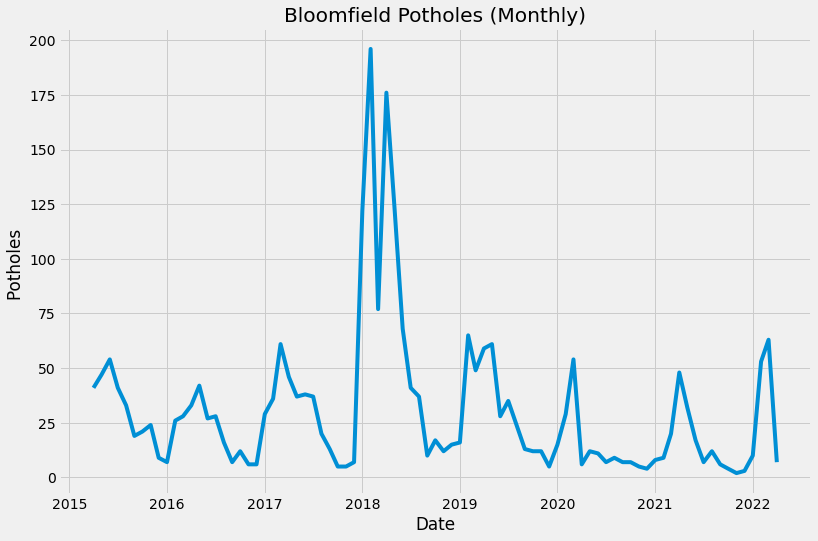

In [91]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(1 , figsize=(12, 8) )
ax.set_title('Bloomfield Potholes (Monthly)')
ax.plot(df['t'],df['num_potholes'])
ax.set_ylabel('Potholes ')
ax.set_xlabel('Date')


In [ ]:
conn.commit()
conn.close()

## Security note
---

Note, that many of the queries we've been doing above may not necessarily be secure, where we're passing strings to the query in Python. 

Here's an extreme example of an SQL injection in a data field from everyone's favorite nerdy webcomic:

![Image](https://imgs.xkcd.com/comics/exploits_of_a_mom.png)

Your database admins wherever you work may have more stringent requirements on how you sanitize things when you're accessing the production database!